# Exploring the generated chunks of code
# Were they in the training dataset?

To run this notebook,
- prepare the results first by running the script `./generate_code_chunks.sh`
- put your GitHub API token into `GITHUB_API_TOKEN` variable to be able to check if a chunk of code is available on GitHub

In [ ]:
%set_env GITHUB_API_TOKEN=###########YOUR_TOKEN####################

In [2]:
from github_search import get_gh_occurence_count, search_github

import pandas as pd
import matplotlib.pyplot as plt

import time

In [10]:
# Load the results, sort by perplexity
df = pd.read_csv("code_chunks_and_scores.csv")
df = df.sort_values(by="perp_3b", ignore_index=True)
df.head()

,Unnamed: 0,texts,perp_1b,perp_3b,zlib_entropy,perp_3b_lowercase,sliding_window
0,1,\n<?php\nclass Vote_model extends CI_Model\n{\...,1.877654,1.938361,308,1.920007,1.834772
1,6,.27\n---\nlayout: watch\ntitle: TLP40:17:17\np...,4.279292,3.829438,126,5.757754,4.287504
2,0,import {\n public static function(int x) {...,3.825781,3.961153,215,4.115553,3.624401
3,4,\n## 36. Combination Sum III (Hard)\n\n### **链...,3.146179,4.491643,495,4.202165,2.638433
4,3,23.0\n\n# Data visualization tools\n\n- data v...,4.572522,4.968865,253,4.528252,1.918337


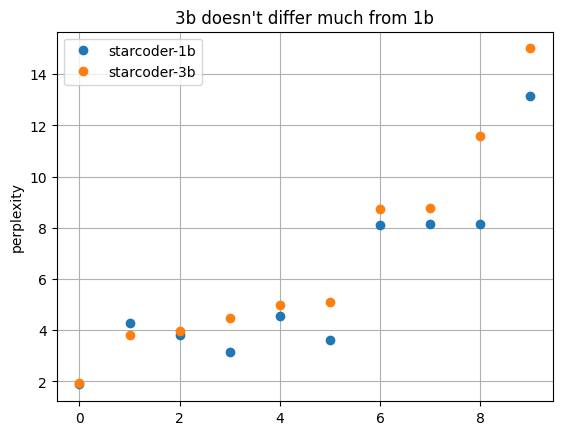

In [13]:
plt.title("3b doesn't differ much from 1b")
plt.plot(df.perp_1b, "o", label="starcoder-1b")
plt.plot(df.perp_3b, "o", label="starcoder-3b")
plt.ylabel("perplexity")
plt.legend()
plt.grid()

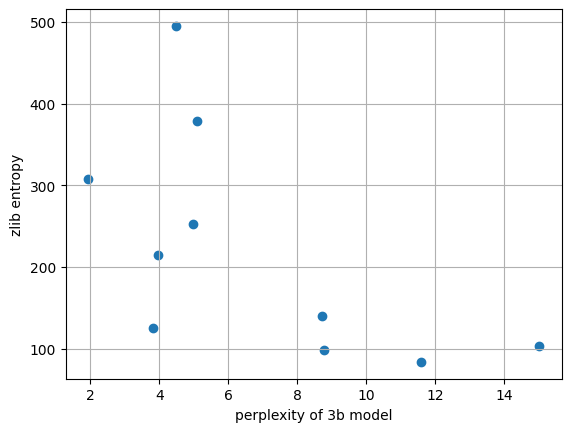

In [25]:
plt.scatter(df.perp_3b, df.zlib_entropy)
plt.xlabel("perplexity of 3b model")
plt.ylabel("zlib entropy")
plt.grid()

In [24]:
print(df.texts[5][:50])
r = search_github(df.texts[5][:50])
r.raise_for_status()
r.json()["total_count"]

/usr
---
id: gatsby-plugin-mdx-test
slug: /gatsby/


0

Not found on GitHub :(